In [1]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
from mmcv import Config
import os.path as osp

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.models import build_segmentor

classes = ('R', 'G', 'B')
palette = [[0, 0, 255], [0, 255, 0], [255, 0, 0]]

file_root = '/home/andy/Downloads/private/mmsegmentation/demo/psp_line_remove'
cfg = Config.fromfile(osp.join(file_root, '../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'))
cfg.model.decode_head.num_classes = 3
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

checkpoint_file='/home/andy/Downloads/private/mmsegmentation/work_dirs/datamy/latest.pth'
model = build_segmentor(cfg.model)

model.CLASSES = classes
model.PALETT = palette
model.cfg = cfg  # save the config in the model for convenience
model.to('cuda:0')
model.eval()

img='../data/img_dir/1655988351.371892929.jpg'
result = inference_segmentor(model, img)


/spc/home/andy/Downloads/private/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/spc/home/andy/Downloads/private/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


In [41]:
result = inference_segmentor(model, img)


In [4]:
from mmcv.parallel import collate, scatter
# from mmcv.runner import load_checkpoint

from mmseg.datasets.pipelines import Compose
import mmcv, torch

class LoadImage:
    """A simple pipeline to load image."""

    def __call__(self, results):
        """Call function to load images into results.

        Args:
            results (dict): A result dict contains the file name
                of the image to be read.

        Returns:
            dict: ``results`` will be returned containing loaded image.
        """

        if isinstance(results['img'], str):
            results['filename'] = results['img']
            results['ori_filename'] = results['img']
        else:
            results['filename'] = None
            results['ori_filename'] = None
        img = mmcv.imread(results['img'])
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        return results
    
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            # dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

# import torch
imgs = [img]
device = next(model.parameters()).device  # model device
# build the data pipeline
test_pipeline = [LoadImage()] + cfg.data.test.pipeline[1:]
test_pipeline = Compose(test_pipeline)

data = []
for img in imgs:
    img_data = dict(img=img)
    img_data = test_pipeline(img_data)
    data.append(img_data)
data = collate(data, samples_per_gpu=len(imgs))
data = scatter(data, [device])[0]
with torch.no_grad():
    result = model.whole_inference(data['img'][0], img_meta=data['img_metas'][0], rescale=True)

NameError: name 'mmcv' is not defined

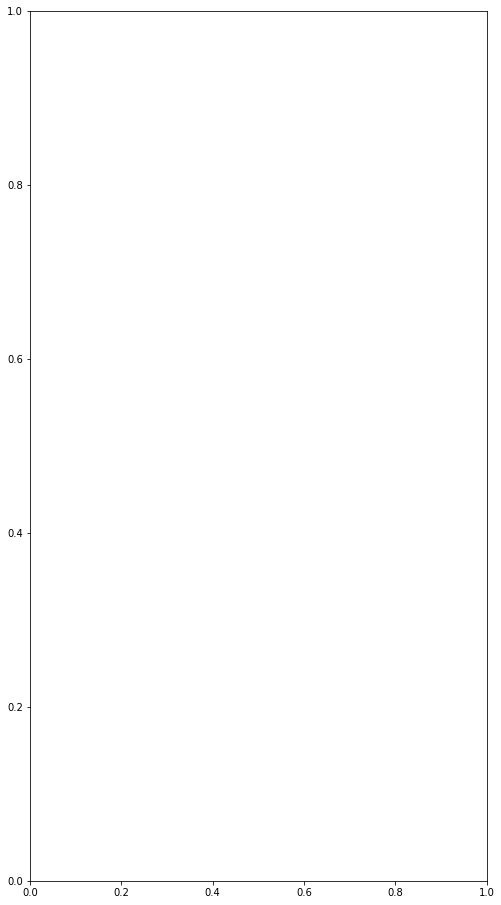

In [1]:
import matplotlib.pylab as plt
plt.figure(figsize=(18,16))
plt.subplot(1,2,1)
ori_img = mmcv.imread(img)
plt.imshow(ori_img)
# plt.show(result)
import numpy as np
plt.subplot(1,2,2)

result_img = np.array(result.squeeze(0).cpu()).transpose(1,2,0) * cfg.img_norm_cfg['std']
# result_img = np.array(result.squeeze(0).cpu()).transpose(1,2,0)
plt.imshow((result_img).astype(np.uint8))
print(f'max={result_img.max()}, min={result_img.min()}')
plt.show()


In [14]:
len(result)

1